In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from math import ceil
from tqdm.notebook import tqdm
import wandb
from torch_lr_finder import LRFinder
from utils import EarlyStopping
import utils
import plotly.express as px

In [2]:
from scipy import ndimage
from pickle import load

In [3]:
run = wandb.init(project='HyperView-initial', reinit=True)
# wandb.init(mode="disabled") # in case of testing code

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jcharyton (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Paths definition

In [4]:
train_data_directory = r'../../train_data'
test_data_directory = r'../../test_data'
saved_models_directory = r'../../saved_models'
submissions_directory = r'../../submissions'

### Load mean and std values of training dataset

In [5]:
means_stds_arrays = np.load(os.path.join(
    train_data_directory, 'means_stds_values_training_data.npz'))
means = np.array(means_stds_arrays['means'])
stds = np.array(means_stds_arrays['stds'])

### Load scalers for parameters

In [6]:
parameters_scalers = dict()
parameters_scalers['P'] = load((open(os.path.join(train_data_directory, 'standard_scaler_P.pkl'), 'rb')))
parameters_scalers['K'] = load((open(os.path.join(train_data_directory, 'standard_scaler_K.pkl'), 'rb')))
parameters_scalers['Mg'] = load((open(os.path.join(train_data_directory, 'standard_scaler_Mg.pkl'), 'rb')))
parameters_scalers['pH'] = load((open(os.path.join(train_data_directory, 'standard_scaler_pH.pkl'), 'rb')))

In [7]:
parameters_scalers['P'].mean_

array([70.30265589])

### Dataset definition

In [8]:
class HyperViewDataset(Dataset):
    def __init__(self, gt_file, img_dir, transform=True, means=None, stds=None, train_transforms=False, parameters_scalers=None):
        self.img_dir = img_dir
        if gt_file is not None:
            self.gt = pd.read_csv(gt_file)[['sample_index', 'P', 'K', 'Mg', 'pH']]
        else:
            self.gt = None
        self.transform = transform  # whether to perform transformation of input data
        # whether to perform transformations like on training data
        self.train_transforms = train_transforms

        if self.train_transforms:
            self.training_transforms_composition = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.4), transforms.RandomVerticalFlip(p=0.4)])

        self.means = means  # mean values for every band used to normalize data
        self.stds = stds  # std values for every band used to normalize data

        self.img_files = np.array(
            sorted(
                glob(os.path.join(img_dir, "*.npz")),
                key=lambda x: int(os.path.basename(x).replace(".npz", "")),
            )
        )

        if parameters_scalers is not None:
            self.scaler_P = parameters_scalers['P']
            self.scaler_K = parameters_scalers['K']
            self.scaler_Mg = parameters_scalers['Mg']
            self.scaler_pH = parameters_scalers['pH']
        else:
            self.scaler_P = None
            self.scaler_K = None
            self.scaler_Mg = None
            self.scaler_pH = None

    def pad_to_minimum_size(self, min_size, image):
        # pads numpy array to defined in `min_size` minimum size of array (w, h)
        c, h, w = image.shape
        h_diff = (min_size - h)/2
        w_diff = (min_size - w)/2

        if not h_diff.is_integer():
            h_pad1 = int(h_diff - 0.5)
            h_pad2 = int(h_diff + 0.5)
        else:
            h_pad1 = h_pad2 = int(h_diff)

        if not w_diff.is_integer():
            w_pad1 = int(w_diff - 0.5)
            w_pad2 = int(w_diff + 0.5)
        else:
            w_pad1 = w_pad2 = int(w_diff)

        # check if any padding is bigger than zero
        if h_pad1+h_pad2+w_pad1+h_pad2 == 0:
            return image
        else:
            return transforms.functional.pad(image, (w_pad1, h_pad1, w_pad2, h_pad2), fill=0)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # load hyperspectral image to array
        img_arr = np.ma.MaskedArray(**np.load(self.img_files[idx]))
        img_tensor = torch.as_tensor(img_arr.data, dtype=torch.float)
        # Inverting mask is necessary due to masking method in numpy
        img_tensor_mask = ~torch.as_tensor(img_arr.mask)
        img_masked_tensor = torch.mul(img_tensor, img_tensor_mask)

        if self.transform:
            img_masked_tensor_transformed = transforms.functional.normalize(
                img_masked_tensor, mean=self.means.tolist(), std=self.stds.tolist())
            img_masked_tensor_transformed = self.pad_to_minimum_size(
                300, img_masked_tensor_transformed)
            if self.train_transforms:
                img_masked_tensor_transformed = self.training_transforms_composition(
                    img_masked_tensor_transformed)
            img_result_tensor = img_masked_tensor_transformed
        else:
            img_result_tensor = img_masked_tensor
        # load labels
        if self.gt is not None:
            P_gt = self.gt.loc[idx, 'P']
            K_gt = self.gt.loc[idx, 'K']
            Mg_gt = self.gt.loc[idx, 'Mg']
            pH_gt = self.gt.loc[idx, 'pH']
            sample_index = self.gt.loc[idx, 'sample_index']
            
            if self.scaler_P is not None:
                assert self.scaler_K is not None
                assert self.scaler_Mg is not None
                assert self.scaler_pH is not None
                
                P_gt = self.scaler_P.transform(np.array(P_gt).reshape(1, -1))[0][0]
                K_gt = self.scaler_K.transform(np.array(K_gt).reshape(1, -1))[0][0]
                Mg_gt = self.scaler_Mg.transform(np.array(Mg_gt).reshape(1, -1))[0][0]
                pH_gt = self.scaler_pH.transform(np.array(pH_gt).reshape(1, -1))[0][0]
                

            sample = {'image': img_result_tensor, 'P': P_gt,
                      'K': K_gt, 'Mg': Mg_gt, 'pH': pH_gt, 'sample_index': sample_index}
        else:
            sample = {'image': img_result_tensor}

        return sample

In [9]:
train_data_whole = HyperViewDataset(os.path.join(train_data_directory, 'train_gt.csv'), os.path.join(
    train_data_directory, 'train_data'), True, means, stds, train_transforms=True, parameters_scalers=parameters_scalers)

In [10]:
train_dataset, validation_dataset = random_split(train_data_whole, [1000, 732], generator=torch.Generator().manual_seed(22))
# train_dataset = torch.utils.data.Subset(train_data_whole, list(range(0, 1400)))
# validation_dataset = torch.utils.data.Subset(train_data_whole, list(range(1400, len(train_data_whole))))

### Model Definition

In [11]:
import torchvision
from torchvision import datasets, models, transforms

In [12]:
class ResNetCNN(nn.Module):
    def __init__(self, pretrained):
        super().__init__()
        self.resnet_model = models.resnet50(pretrained=False)

        self.resnet_model.conv1 = nn.Conv2d(150, 64, kernel_size=(
            7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet_model.fc = nn.Linear(
            in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.resnet_model(x)
#         return {'P': x[0], 'K': x[1], 'Mg': x[2], 'pH': x[3]}
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
BATCH_SIZE = 12
EPOCHS = 300

In [15]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, pin_memory=True, drop_last=True, num_workers=4, shuffle=True)

In [16]:
model = ResNetCNN(pretrained=False)
model.to(device)

ResNetCNN(
  (resnet_model): ResNet(
    (conv1): Conv2d(150, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

#### Load pretrained weights

##### Download weights for resnet50

In [17]:
url = "https://download.pytorch.org/models/resnet50-0676ba61.pth"
state = torch.utils.model_zoo.load_url(url)

In [18]:
state_resnet = {f'resnet_model.{k}': v for k, v in state.items()}

In [19]:
# Adapt last layer (FC) to 1 class output
state_resnet['resnet_model.fc.weight'] = state_resnet['resnet_model.fc.weight'][:1, :]
state_resnet['resnet_model.fc.bias'] = state_resnet['resnet_model.fc.bias'][:1]

In [20]:
# Adapt conv1 layer to 150 input channels
conv1_weight = state_resnet['resnet_model.conv1.weight']
conv1_dtype = conv1_weight.dtype
conv1_weight = conv1_weight.float()
repeat = int(ceil(150 / 3))
conv1_weight = conv1_weight.repeat(1, repeat, 1, 1)[:, :150, :, :] # copy first 3 channels repeat-times
conv1_weight *= (3 / float(150))
conv1_weight = conv1_weight.to(conv1_dtype)
state_resnet['resnet_model.conv1.weight'] = conv1_weight

In [21]:
model.load_state_dict(state_resnet)

<All keys matched successfully>

### Overfitting on single batch of data

In [64]:
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [65]:
train_data_single_batch = next(iter(train_dataloader))

In [66]:
train_data_single_batch['image'][0].shape

torch.Size([150, 300, 300])

In [67]:
train_data_single_batch['image'].to(device, dtype=torch.float).shape

torch.Size([12, 150, 300, 300])

In [68]:
output = model(train_data_single_batch['image'].to(device, dtype=torch.float))

In [69]:
output.shape

torch.Size([12, 1])

In [70]:
output

tensor([[-1.5654],
        [ 0.4550],
        [-0.6471],
        [ 1.5389],
        [-0.9248],
        [-1.2923],
        [-1.5832],
        [-1.2502],
        [-2.2619],
        [-0.4820],
        [-1.1169],
        [-1.8853]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [71]:
stacked_gt = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device)
stacked_gt

tensor([[-0.7053],
        [ 0.6644],
        [-0.2544],
        [-0.1187],
        [-0.7832],
        [ 0.8305],
        [-1.3291],
        [ 1.5832],
        [ 0.8678],
        [-0.3289],
        [ 0.2033],
        [ 0.4610]], device='cuda:0', dtype=torch.float64)

In [72]:
loss_func(output, stacked_gt)

tensor(1.2851, device='cuda:0', grad_fn=<L1LossBackward0>)

#### Sprawdzenie czy inwersja skalowania działa właściwie

In [73]:
gt_df = pd.read_csv(os.path.join(train_data_directory, 'train_gt.csv'))[
    ['sample_index', 'P', 'K', 'Mg', 'pH']]

In [74]:
train_data_single_batch['sample_index']

tensor([1136, 1537, 1479, 1540,  743,  963,  641,  848,  372, 1427, 1698,   73])

In [75]:
gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ 49.5],
       [ 89.9],
       [ 62.8],
       [ 66.8],
       [ 47.2],
       [ 94.8],
       [ 31.1],
       [117. ],
       [ 95.9],
       [ 60.6],
       [ 76.3],
       [ 83.9]])

In [77]:
scaler = getattr(train_dataset.dataset, f'scaler_P')
scaler

StandardScaler()

In [78]:
scaler.inverse_transform(stacked_gt.cpu())

array([[ 49.5],
       [ 89.9],
       [ 62.8],
       [ 66.8],
       [ 47.2],
       [ 94.8],
       [ 31.1],
       [117. ],
       [ 95.9],
       [ 60.6],
       [ 76.3],
       [ 83.9]])

In [79]:
scaler.inverse_transform(stacked_gt.cpu()) == gt_df.loc[train_data_single_batch['sample_index'], 'P'].values.reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

#### Właściwa pętla overfit

In [80]:
img_data_device = train_data_single_batch['image'].to(
    device, dtype=torch.float)
stacked_gt_device = train_data_single_batch['P'].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)
scaler = getattr(train_dataset.dataset, f'scaler_P')

model = ResNetCNN(False).to(device)
# load pretrained weights
model.load_state_dict(state_resnet)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()
model.train()

for epoch in range(301):

    output = model(img_data_device)
    loss = loss_func(output, stacked_gt_device)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output_cpu = output.detach().cpu().numpy()
    stacked_gt_cpu = stacked_gt_device.cpu().numpy()
    
    output_cpu_inversed = scaler.inverse_transform(output_cpu)
    stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

    # Calculate MSE for each class
    mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
    mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)

    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss.data.cpu().numpy()}, MSE: {mse}, MSE from unscaled values: {mse_inversed}')

epoch: 0, loss: 2.7809462547302246, MSE: [2.7809465], MSE from unscaled values: [2419.5056]
epoch: 10, loss: 0.7690430879592896, MSE: [0.76904297], MSE from unscaled values: [669.09033]
epoch: 20, loss: 0.5729861259460449, MSE: [0.5729862], MSE from unscaled values: [498.51505]
epoch: 30, loss: 0.4278200566768646, MSE: [0.42782006], MSE from unscaled values: [372.21616]
epoch: 40, loss: 0.3470759093761444, MSE: [0.3470759], MSE from unscaled values: [301.96628]
epoch: 50, loss: 0.33599597215652466, MSE: [0.33599594], MSE from unscaled values: [292.32648]
epoch: 60, loss: 0.334554523229599, MSE: [0.33455452], MSE from unscaled values: [291.07236]
epoch: 70, loss: 0.33414214849472046, MSE: [0.33414218], MSE from unscaled values: [290.71353]
epoch: 80, loss: 0.3335133492946625, MSE: [0.33351335], MSE from unscaled values: [290.1665]
epoch: 90, loss: 0.33237630128860474, MSE: [0.33237627], MSE from unscaled values: [289.17725]
epoch: 100, loss: 0.3300020098686218, MSE: [0.33000198], MSE fr

### Training Definition

In [22]:
parameter = 'pH'

In [23]:
save_name = "checkpoint_state_dict_ResNet50_16_05_2022_Single_Parameter_Scaled_PretrainedModel_{}".format(parameter)
save_name

'checkpoint_state_dict_ResNet50_16_05_2022_Single_Parameter_Scaled_PretrainedModel_pH'

In [24]:
model_name = save_name+'.pth'

In [25]:
# save subsets indices to text files
np.array(train_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_train_indices.txt'), sep='|')
np.array(validation_dataset.indices).tofile(os.path.join(saved_models_directory, 'DataSubsets_indices', save_name+'_validation_indices.txt'), sep='|')

In [26]:
model = ResNetCNN(False).to(device)
# load pretrained weights
model.load_state_dict(state_resnet)

<All keys matched successfully>

In [27]:
wandb.watch(model, log="None", log_freq=20)

[]

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [29]:
loss_func = torch.nn.MSELoss()

#### Find LR

In [89]:
from torch_lr_finder.lr_finder import TrainDataLoaderIter

In [90]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return (torch.as_tensor(batch_data['image'], dtype=torch.float),
                torch.as_tensor(batch_data['P'].unsqueeze(dim=0).permute(1, 0), dtype=torch.float))

In [91]:
lr_finder = LRFinder(model, optimizer, loss_func, device=device)
lr_finder.range_test(CustomTrainIter(train_dataloader),
                     start_lr=0.00001, end_lr=100, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.06E-01


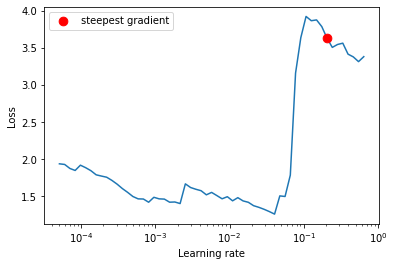

In [92]:
lr_finder.plot()
lr_finder.reset()

In [93]:
2.06E-01

0.206

### Training

In [32]:
patience_scheduler_overfit = 5
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                                       factor=0.6, patience=patience_scheduler_overfit,
                                                       threshold=0.0001, threshold_mode='abs')

In [33]:
early_stopping = utils.EarlyStopping(patience=(2*patience_scheduler_overfit)+3, verbose=True,
                                     path=os.path.join(saved_models_directory, 'checkpoint_state_dict.pth'))

#### Logging training informations for W&B

In [34]:
config = wandb.config
config.model = 'resnet50'
config.optimizer = 'AdamW'
config.loss_function = 'MSELoss'
config.learning_rate_start = optimizer.param_groups[0]["lr"]
# config.momentum = optimizer.param_groups[0]["momentum"]
config.momentum = None
config.weight_decay = optimizer.param_groups[0]["weight_decay"]
config.scheduler = 'ReduceLROnPlateau'
config.scheduler_factor = 0.6
config.scheduler_patience = 5
config.scheduler_threshold = 0.0001
config.batch_size = BATCH_SIZE
config.notes = 'ResNet50 Parameter {} SCALED Training split:1000, Validation: 732. Scaled predicted variable. Model pretrained on Imagenet'.format(parameter)
config.parameter = parameter

In [35]:
previous_epochs = 0  # how many epochs have been done previously if resuming

In [36]:
scaler = getattr(train_dataset.dataset, f'scaler_{parameter}')

for epoch in range(previous_epochs, EPOCHS+previous_epochs):
    # TRAINING Part
    model.train()
    train_loss = []
    mse_train_list = []
    mse_inversed_train_list = []

    bar = tqdm(train_dataloader, position=0, leave=False,
               desc=f'epoch {epoch} training data')
    i = 0
    for train_data in bar:  # for each training step
        i += 1
        img_data_device = train_data['image'].to(device, dtype=torch.float)
#         stacked_gt_device = torch.stack((train_data['P'], train_data['K'], train_data['Mg'], train_data['pH'])).transpose(
#             0, 1).to(device, dtype=torch.float)
        stacked_gt_device = train_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

        output = model(img_data_device)

        loss = loss_func(output, stacked_gt_device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss)

        output_cpu = output.detach().cpu().numpy()
        stacked_gt_cpu = stacked_gt_device.cpu().numpy()
        
        output_cpu_inversed = scaler.inverse_transform(output_cpu)
        stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

        # Calculate MSE for each class
        mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
        mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
        mse_train_list.append(mse)
        mse_inversed_train_list.append(mse_inversed)
        

        if i % 10 == 0:  # log every 10 batches
            train_log_dict = dict()
            train_log_dict['batch_number'] = i
            train_log_dict['epoch'] = epoch
            train_log_dict['train_batch_loss'] = loss
            train_log_dict['train_batch_MSE_{}'.format(parameter)] = mse[0]
            wandb.log(train_log_dict)

    avg_train_loss = torch.stack(train_loss).mean().item()
    avg_train_mse = torch.as_tensor(
        np.array(mse_train_list)).mean(axis=0).numpy().tolist()
    avg_train_mse_inversed = torch.as_tensor(
        np.array(mse_inversed_train_list)).mean(axis=0).numpy().tolist()

    print(
        f'epoch: {epoch}, LR: {optimizer.param_groups[0]["lr"]}, train loss: {avg_train_loss}, train MSE: {avg_train_mse}, train MSE from unscaled values: {avg_train_mse_inversed}')
    wandb.log({'epoch': epoch, 'average_train_loss': avg_train_loss, 'average_train_MSE_{}'.format(parameter): avg_train_mse_inversed[0]})

    # VALIDATION Part
    model.eval()
    val_bar = tqdm(validation_dataloader, position=0,
                   leave=False, desc=f'epoch {epoch} validation data')
    with torch.no_grad():
        val_loss = []
        mse_val_list = []
        mse_inversed_val_list = []
        for val_data in val_bar:
            img_data_device = val_data['image'].to(device, dtype=torch.float)
#             stacked_gt_device = torch.stack((val_data['P'], val_data['K'], val_data['Mg'], val_data['pH'])).transpose(
#                 0, 1).to(device, dtype=torch.float)
            stacked_gt_device =  val_data[parameter].unsqueeze(dim=0).permute(1, 0).to(device, dtype=torch.float)

            output = model(img_data_device)

            loss = loss_func(output, stacked_gt_device)
            val_loss.append(loss)

            output_cpu = output.detach().cpu().numpy()
            stacked_gt_cpu = stacked_gt_device.cpu().numpy()
            
            output_cpu_inversed = scaler.inverse_transform(output_cpu)
            stacked_gt_cpu_inversed = scaler.inverse_transform(stacked_gt_cpu)

            # Calculate MSE for each class
            mse = np.mean((stacked_gt_cpu - output_cpu) ** 2, axis=0)
            mse_val_list.append(mse)
            mse_inversed = np.mean((stacked_gt_cpu_inversed - output_cpu_inversed) ** 2, axis=0)
            mse_inversed_val_list.append(mse_inversed)


        avg_val_loss = torch.stack(val_loss).mean().item()
        avg_val_mse = torch.as_tensor(
            np.array(mse_val_list)).mean(axis=0).numpy().tolist()
        avg_val_mse_inversed = torch.as_tensor(
            np.array(mse_inversed_val_list)).mean(axis=0).numpy().tolist()

        print(f'epoch: {epoch}, validation loss: {avg_val_loss}, validation MSE: {avg_val_mse}, validation MSE from unscaled values: {avg_val_mse_inversed}')
        # using MSE from inversed values in W&B logger to make it compatible with previous runs in W&B
        wandb.log({'epoch': epoch, 'average_val_loss': avg_val_loss, 'average_validation_MSE_{}'.format(parameter): avg_val_mse_inversed[0]}) 

        scheduler.step(avg_val_loss)
        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

epoch 0 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 0, LR: 0.01, train loss: 3.674004077911377, train MSE: [3.674004554748535], train MSE from unscaled values: [0.24878886342048645]


epoch 0 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 0, validation loss: 4.108872413635254, validation MSE: [4.108872890472412], validation MSE from unscaled values: [0.27823638916015625]
Validation loss decreased (inf --> 4.108872).  Saving model ...


epoch 1 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 1, LR: 0.01, train loss: 1.0523055791854858, train MSE: [1.0523056983947754], train MSE from unscaled values: [0.07125792652368546]


epoch 1 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 1, validation loss: 1.3177427053451538, validation MSE: [1.3177424669265747], validation MSE from unscaled values: [0.08923225849866867]
Validation loss decreased (4.108872 --> 1.317743).  Saving model ...


epoch 2 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 2, LR: 0.01, train loss: 0.9917969703674316, train MSE: [0.9917969107627869], train MSE from unscaled values: [0.06716051697731018]


epoch 2 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 2, validation loss: 1.0439724922180176, validation MSE: [1.0439724922180176], validation MSE from unscaled values: [0.07069364190101624]
Validation loss decreased (1.317743 --> 1.043972).  Saving model ...


epoch 3 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 3, LR: 0.01, train loss: 0.9739422798156738, train MSE: [0.9739422798156738], train MSE from unscaled values: [0.06595147401094437]


epoch 3 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 3, validation loss: 0.9068083167076111, validation MSE: [0.9068083167076111], validation MSE from unscaled values: [0.06140543147921562]
Validation loss decreased (1.043972 --> 0.906808).  Saving model ...


epoch 4 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 4, LR: 0.01, train loss: 0.9220015406608582, train MSE: [0.9220016002655029], train MSE from unscaled values: [0.06243424862623215]


epoch 4 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 4, validation loss: 0.9160418510437012, validation MSE: [0.916041910648346], validation MSE from unscaled values: [0.06203068792819977]
EarlyStopping counter: 1 out of 13


epoch 5 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 5, LR: 0.01, train loss: 0.9292768836021423, train MSE: [0.9292768836021423], train MSE from unscaled values: [0.06292691826820374]


epoch 5 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 5, validation loss: 0.8901443481445312, validation MSE: [0.890144407749176], validation MSE from unscaled values: [0.06027700752019882]
Validation loss decreased (0.906808 --> 0.890144).  Saving model ...


epoch 6 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 6, LR: 0.01, train loss: 0.9024866819381714, train MSE: [0.9024866819381714], train MSE from unscaled values: [0.061112772673368454]


epoch 6 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 6, validation loss: 1.1113308668136597, validation MSE: [1.1113308668136597], validation MSE from unscaled values: [0.07525486499071121]
EarlyStopping counter: 1 out of 13


epoch 7 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 7, LR: 0.01, train loss: 0.9006816148757935, train MSE: [0.9006816744804382], train MSE from unscaled values: [0.06099054589867592]


epoch 7 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 7, validation loss: 1.277255654335022, validation MSE: [1.2772555351257324], validation MSE from unscaled values: [0.08649063110351562]
EarlyStopping counter: 2 out of 13


epoch 8 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 8, LR: 0.01, train loss: 0.906896710395813, train MSE: [0.9068966507911682], train MSE from unscaled values: [0.06141141057014465]


epoch 8 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 8, validation loss: 0.8974988460540771, validation MSE: [0.8974988460540771], validation MSE from unscaled values: [0.0607750304043293]
EarlyStopping counter: 3 out of 13


epoch 9 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 9, LR: 0.01, train loss: 0.9069674015045166, train MSE: [0.9069674611091614], train MSE from unscaled values: [0.06141619384288788]


epoch 9 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 9, validation loss: 0.9861599206924438, validation MSE: [0.9861599206924438], validation MSE from unscaled values: [0.06677880138158798]
EarlyStopping counter: 4 out of 13


epoch 10 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 10, LR: 0.01, train loss: 0.8903486728668213, train MSE: [0.8903486728668213], train MSE from unscaled values: [0.06029084697365761]


epoch 10 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 10, validation loss: 1.0306388139724731, validation MSE: [1.0306388139724731], validation MSE from unscaled values: [0.06979072839021683]
EarlyStopping counter: 5 out of 13


epoch 11 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 11, LR: 0.01, train loss: 0.8835589289665222, train MSE: [0.8835588693618774], train MSE from unscaled values: [0.05983106791973114]


epoch 11 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 11, validation loss: 0.9302177429199219, validation MSE: [0.9302178621292114], validation MSE from unscaled values: [0.06299062073230743]
EarlyStopping counter: 6 out of 13


epoch 12 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 12, LR: 0.006, train loss: 0.8774441480636597, train MSE: [0.8774440884590149], train MSE from unscaled values: [0.0594170019030571]


epoch 12 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 12, validation loss: 0.9930845499038696, validation MSE: [0.9930844902992249], validation MSE from unscaled values: [0.06724771112203598]
EarlyStopping counter: 7 out of 13


epoch 13 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 13, LR: 0.006, train loss: 0.8768287897109985, train MSE: [0.8768288493156433], train MSE from unscaled values: [0.0593753308057785]


epoch 13 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 13, validation loss: 0.9551855325698853, validation MSE: [0.9551854133605957], validation MSE from unscaled values: [0.06468133628368378]
EarlyStopping counter: 8 out of 13


epoch 14 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 14, LR: 0.006, train loss: 0.901898980140686, train MSE: [0.9018988609313965], train MSE from unscaled values: [0.06107297167181969]


epoch 14 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 14, validation loss: 0.8923693299293518, validation MSE: [0.8923693895339966], validation MSE from unscaled values: [0.06042768061161041]
EarlyStopping counter: 9 out of 13


epoch 15 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 15, LR: 0.006, train loss: 0.874387800693512, train MSE: [0.874387800693512], train MSE from unscaled values: [0.05921004340052605]


epoch 15 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 15, validation loss: 1.0387870073318481, validation MSE: [1.0387870073318481], validation MSE from unscaled values: [0.07034249603748322]
EarlyStopping counter: 10 out of 13


epoch 16 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 16, LR: 0.006, train loss: 0.8756430149078369, train MSE: [0.8756430745124817], train MSE from unscaled values: [0.05929504707455635]


epoch 16 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 16, validation loss: 0.9330723881721497, validation MSE: [0.9330724477767944], validation MSE from unscaled values: [0.06318392604589462]
EarlyStopping counter: 11 out of 13


epoch 17 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 17, LR: 0.006, train loss: 0.8688809871673584, train MSE: [0.8688809275627136], train MSE from unscaled values: [0.05883714556694031]


epoch 17 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 17, validation loss: 0.8880645036697388, validation MSE: [0.8880645036697388], validation MSE from unscaled values: [0.06013616919517517]
Validation loss decreased (0.890144 --> 0.888065).  Saving model ...


epoch 18 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 18, LR: 0.006, train loss: 0.8645881414413452, train MSE: [0.86458820104599], train MSE from unscaled values: [0.05854644626379013]


epoch 18 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 18, validation loss: 0.8912250399589539, validation MSE: [0.8912250995635986], validation MSE from unscaled values: [0.060350190848112106]
EarlyStopping counter: 1 out of 13


epoch 19 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 19, LR: 0.006, train loss: 0.8718562126159668, train MSE: [0.871856153011322], train MSE from unscaled values: [0.059038616716861725]


epoch 19 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 19, validation loss: 0.9053292870521545, validation MSE: [0.9053293466567993], validation MSE from unscaled values: [0.06130527704954147]
EarlyStopping counter: 2 out of 13


epoch 20 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 20, LR: 0.006, train loss: 0.8587911128997803, train MSE: [0.8587911128997803], train MSE from unscaled values: [0.058153893798589706]


epoch 20 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 20, validation loss: 1.007622480392456, validation MSE: [1.0076225996017456], validation MSE from unscaled values: [0.06823217123746872]
EarlyStopping counter: 3 out of 13


epoch 21 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 21, LR: 0.006, train loss: 0.8544589877128601, train MSE: [0.8544589281082153], train MSE from unscaled values: [0.05786054581403732]


epoch 21 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 21, validation loss: 0.9246557950973511, validation MSE: [0.9246557950973511], validation MSE from unscaled values: [0.06261397898197174]
EarlyStopping counter: 4 out of 13


epoch 22 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 22, LR: 0.006, train loss: 0.8618953227996826, train MSE: [0.8618953824043274], train MSE from unscaled values: [0.05836409702897072]


epoch 22 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 22, validation loss: 0.9119658470153809, validation MSE: [0.9119659066200256], validation MSE from unscaled values: [0.061754681169986725]
EarlyStopping counter: 5 out of 13


epoch 23 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 23, LR: 0.006, train loss: 0.854709267616272, train MSE: [0.8547093272209167], train MSE from unscaled values: [0.05787748843431473]


epoch 23 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 23, validation loss: 0.9239815473556519, validation MSE: [0.9239815473556519], validation MSE from unscaled values: [0.06256832927465439]
EarlyStopping counter: 6 out of 13


epoch 24 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 24, LR: 0.0036, train loss: 0.8540735244750977, train MSE: [0.8540735840797424], train MSE from unscaled values: [0.0578344464302063]


epoch 24 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 24, validation loss: 0.8751295804977417, validation MSE: [0.8751296997070312], validation MSE from unscaled values: [0.05926027148962021]
Validation loss decreased (0.888065 --> 0.875130).  Saving model ...


epoch 25 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 25, LR: 0.0036, train loss: 0.8608514070510864, train MSE: [0.8608512282371521], train MSE from unscaled values: [0.058293405920267105]


epoch 25 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 25, validation loss: 0.9160275459289551, validation MSE: [0.9160274863243103], validation MSE from unscaled values: [0.06202971190214157]
EarlyStopping counter: 1 out of 13


epoch 26 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 26, LR: 0.0036, train loss: 0.8540676832199097, train MSE: [0.8540676236152649], train MSE from unscaled values: [0.05783402919769287]


epoch 26 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 26, validation loss: 0.9433502554893494, validation MSE: [0.9433502554893494], validation MSE from unscaled values: [0.06387989968061447]
EarlyStopping counter: 2 out of 13


epoch 27 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 27, LR: 0.0036, train loss: 0.8419913649559021, train MSE: [0.8419913053512573], train MSE from unscaled values: [0.0570162795484066]


epoch 27 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 27, validation loss: 0.8694759607315063, validation MSE: [0.8694760203361511], validation MSE from unscaled values: [0.058877430856227875]
Validation loss decreased (0.875130 --> 0.869476).  Saving model ...


epoch 28 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 28, LR: 0.0036, train loss: 0.8406648635864258, train MSE: [0.8406648635864258], train MSE from unscaled values: [0.05692645162343979]


epoch 28 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 28, validation loss: 0.891954243183136, validation MSE: [0.8919541835784912], validation MSE from unscaled values: [0.06039956584572792]
EarlyStopping counter: 1 out of 13


epoch 29 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 29, LR: 0.0036, train loss: 0.8361673355102539, train MSE: [0.8361672759056091], train MSE from unscaled values: [0.05662190169095993]


epoch 29 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 29, validation loss: 0.9281396865844727, validation MSE: [0.9281397461891174], validation MSE from unscaled values: [0.06284990161657333]
EarlyStopping counter: 2 out of 13


epoch 30 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 30, LR: 0.0036, train loss: 0.8332686424255371, train MSE: [0.8332687020301819], train MSE from unscaled values: [0.056425612419843674]


epoch 30 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 30, validation loss: 0.8972330093383789, validation MSE: [0.8972331285476685], validation MSE from unscaled values: [0.060757026076316833]
EarlyStopping counter: 3 out of 13


epoch 31 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 31, LR: 0.0036, train loss: 0.8443729877471924, train MSE: [0.8443730473518372], train MSE from unscaled values: [0.057177554816007614]


epoch 31 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 31, validation loss: 0.9107102751731873, validation MSE: [0.9107102155685425], validation MSE from unscaled values: [0.06166965514421463]
EarlyStopping counter: 4 out of 13


epoch 32 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 32, LR: 0.0036, train loss: 0.8358609676361084, train MSE: [0.8358610272407532], train MSE from unscaled values: [0.056601155549287796]


epoch 32 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 32, validation loss: 0.9272467494010925, validation MSE: [0.9272466897964478], validation MSE from unscaled values: [0.0627894401550293]
EarlyStopping counter: 5 out of 13


epoch 33 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 33, LR: 0.0036, train loss: 0.8285706043243408, train MSE: [0.828570544719696], train MSE from unscaled values: [0.05610748007893562]


epoch 33 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 33, validation loss: 0.8872681260108948, validation MSE: [0.88726806640625], validation MSE from unscaled values: [0.060082241892814636]
EarlyStopping counter: 6 out of 13


epoch 34 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 34, LR: 0.00216, train loss: 0.8351059556007385, train MSE: [0.8351060152053833], train MSE from unscaled values: [0.056550033390522]


epoch 34 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 34, validation loss: 0.9073695540428162, validation MSE: [0.9073694348335266], validation MSE from unscaled values: [0.061443425714969635]
EarlyStopping counter: 7 out of 13


epoch 35 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 35, LR: 0.00216, train loss: 0.8167670965194702, train MSE: [0.816767156124115], train MSE from unscaled values: [0.05530819669365883]


epoch 35 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 35, validation loss: 0.8918721079826355, validation MSE: [0.8918721675872803], validation MSE from unscaled values: [0.06039401516318321]
EarlyStopping counter: 8 out of 13


epoch 36 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 36, LR: 0.00216, train loss: 0.8121182918548584, train MSE: [0.8121183514595032], train MSE from unscaled values: [0.0549933984875679]


epoch 36 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 36, validation loss: 0.9170750379562378, validation MSE: [0.9170750975608826], validation MSE from unscaled values: [0.06210065633058548]
EarlyStopping counter: 9 out of 13


epoch 37 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 37, LR: 0.00216, train loss: 0.8161780834197998, train MSE: [0.816178023815155], train MSE from unscaled values: [0.0552683062851429]


epoch 37 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 37, validation loss: 0.8828070759773254, validation MSE: [0.8828070759773254], validation MSE from unscaled values: [0.05978015437722206]
EarlyStopping counter: 10 out of 13


epoch 38 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 38, LR: 0.00216, train loss: 0.7861557006835938, train MSE: [0.7861557006835938], train MSE from unscaled values: [0.053235311061143875]


epoch 38 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 38, validation loss: 0.9088587760925293, validation MSE: [0.9088588356971741], validation MSE from unscaled values: [0.0615442730486393]
EarlyStopping counter: 11 out of 13


epoch 39 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 39, LR: 0.00216, train loss: 0.7944262027740479, train MSE: [0.7944261431694031], train MSE from unscaled values: [0.053795360028743744]


epoch 39 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 39, validation loss: 0.8701767325401306, validation MSE: [0.8701767325401306], validation MSE from unscaled values: [0.05892488732933998]
EarlyStopping counter: 12 out of 13


epoch 40 training data:   0%|          | 0/83 [00:00<?, ?it/s]

epoch: 40, LR: 0.001296, train loss: 0.7970410585403442, train MSE: [0.797041118144989], train MSE from unscaled values: [0.053972434252500534]


epoch 40 validation data:   0%|          | 0/61 [00:00<?, ?it/s]

epoch: 40, validation loss: 0.8739921450614929, validation MSE: [0.8739920854568481], validation MSE from unscaled values: [0.05918324738740921]
EarlyStopping counter: 13 out of 13
Early stopping


#### Saving model state dict and loading

In [37]:
torch.save(model.state_dict(), os.path.join(
    saved_models_directory, model_name+f'_EPOCHS_{epoch}.pth'))

In [38]:
# rename checkpoint.pth
! mv ../../saved_models/checkpoint_state_dict.pth ../../saved_models/checkpoint_state_dict_ResNet50_16_05_2022_Single_Parameter_Scaled_PretrainedModel_pH.pth

In [39]:
# load saved model
modelLoad = ResNetCNN(False)
modelLoad.load_state_dict(torch.load(os.path.join(
    saved_models_directory, 'checkpoint_state_dict_ResNet50_16_05_2022_Single_Parameter_Scaled_PretrainedModel_pH.pth')))

<All keys matched successfully>

In [40]:
modelLoad = modelLoad.to(device)